<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/09_few-to-no-labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [2]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=9)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.1
Using nlpaug v1.1.11
Using skmultilearn
Using sacremoses v0.0.41


# 레이블 부족 문제 다루기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree"/>

## 깃허브 이슈 태거 만들기

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_issue-example-v2.png?raw=1" id="issue-example"/> 

### 데이터 다운로드하기

### 이슈 다운로드 코드

직접 이슈를 다운로드하고 싶다면 파이썬에서 HTTP 요청을 처리하는 대표적인 라이브러리인 _Requests_ 를 사용해 Issues 엔드포인트를 호출할 수 있습니다. 다음은 허깅페이스 트랜스포머스 저장소의 이슈를 다운로드하는 함수입니다.

In [3]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000, 
                 rate_limit=5_000):    
    batch = []
    all_issues = []
    per_page = 100     # 페이지마다 반환되는 이슈 개수
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"
    
    for page in tqdm(range(num_pages)):
        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []   # 다음 번 요청을 위해 비웁니다.
            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
            time.sleep(60 * 60 + 1)
            
    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

`fetch_issues()`를 호출할 때 깃허브의 시간 당 요청 횟수 제한을 넘기지 않도록 이슈를 여러 개의 배치로 다운로드합니다. 이 결과는 _github-issues-transformers.jsonl_ 파일에 저장됩니다. 이 파일의 한 라인은 하나의 이슈를 나타내는 JSON 객체입니다.

### 데이터 준비하기

In [4]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


In [5]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [6]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [7]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블을 출력합니다.
df_counts.to_frame().head(8).T

레이블 개수: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [9]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [11]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [12]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



In [13]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [14]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


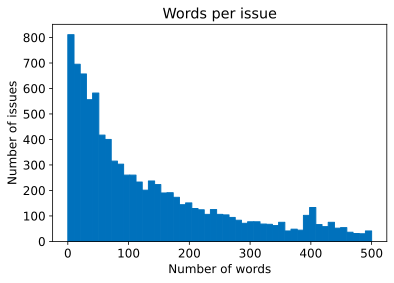

In [15]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

### 훈련 세트 만들기

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [18]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [19]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

### 훈련 슬라이스 만들기

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 마지막 슬라이스를 포함하면 코랩의 경우 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 다음 라인을 주석 처리하세요.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [21]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


## 나이브 베이즈 모델 만들기

In [22]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [23]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

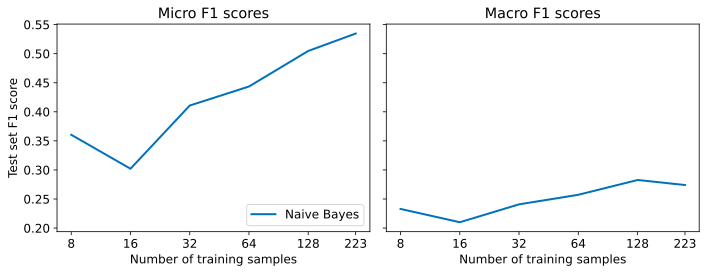

In [26]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## 레이블이 없는 데이터 다루기

In [27]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

In [28]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 lions:       0.066%
토큰 birds:       0.025%
토큰 love:        0.015%
토큰 hunting:     0.013%


In [29]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 cars:        0.001%


In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 cars:        0.139%
토큰 animals:     0.006%


In [31]:
from transformers import pipeline

# CPU에서 실행하려면 device=0을 삭제하세요.
pipe = pipeline("zero-shot-classification", device=0)

In [32]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [33]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [34]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [35]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
        output_dict=True)

In [36]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

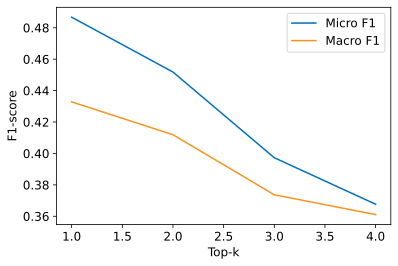

In [37]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [38]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

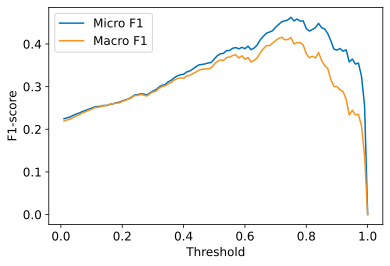

In [39]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [40]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'최상의 임곗값 (마이크로): {best_t}, F1-점수 {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'최상의 임곗값 (마크로): {best_t}, F1-점수 {best_macro:.2f}.')

최상의 임곗값 (마이크로): 0.75, F1-점수 0.46.
최상의 임곗값 (마크로): 0.72, F1-점수 0.42.


In [41]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

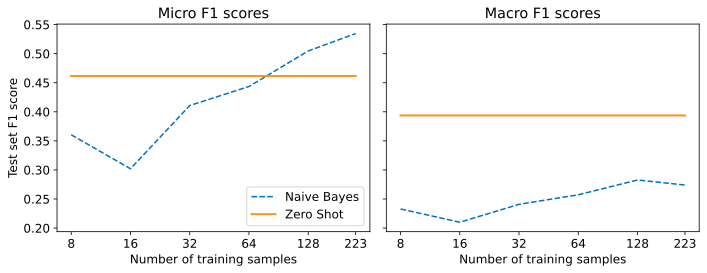

In [42]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

## 레이블이 적은 데이터 다루기

### 데이터 증식

In [43]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"원본 텍스트: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to silently
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your
tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [44]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"원본 텍스트: {text}")
print(f"증식된 텍스트: {aug.augment(text)}")

원본 텍스트: Transformers are the most popular toys
증식된 텍스트: ['transformers have the most available toys']


In [45]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [46]:
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    # 증식 결과를 펼쳐서 레이블에 정렬합니다!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

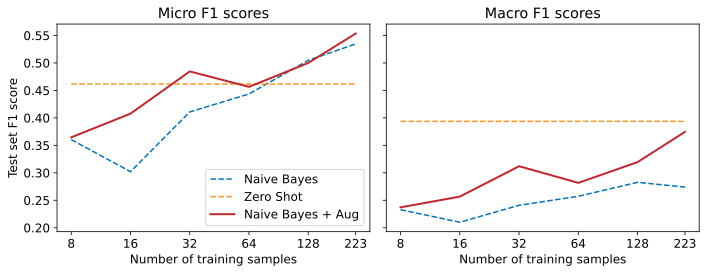

In [47]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

### 임베딩을 룩업 테이블로 사용하기

**이 절의 코드는 [09_few_to_no_labels_with_faiss.ipynb](https://github.com/rickiepark/nlp-with-transformers/blob/main/09_few_to_no_labels_with_faiss.ipynb) 노트북에 있습니다**

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_nearest-neighbours.png?raw=1" id="nearest-neighbours"/>

In [48]:
# 깃허브에서 09_few_to_no_labels_with_faiss.ipynb의 결과를 다운로드하여 점수 딕셔너리에 추가합니다.
!wget https://bit.ly/3QZRsHS -O 09_results_of_faiss.gz

import joblib

embedding_results = joblib.load('09_results_of_faiss.gz')
macro_scores["Embedding"] = embedding_results["macro"]["Embedding"]
micro_scores["Embedding"] = embedding_results["micro"]["Embedding"]

--2023-03-09 03:27:21--  https://bit.ly/3QZRsHS
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/nlp-with-transformers/raw/main/09_results_of_faiss.gz [following]
--2023-03-09 03:27:21--  https://github.com/rickiepark/nlp-with-transformers/raw/main/09_results_of_faiss.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-transformers/main/09_results_of_faiss.gz [following]
--2023-03-09 03:27:21--  https://raw.githubusercontent.com/rickiepark/nlp-with-transformers/main/09_results_of_faiss.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubu

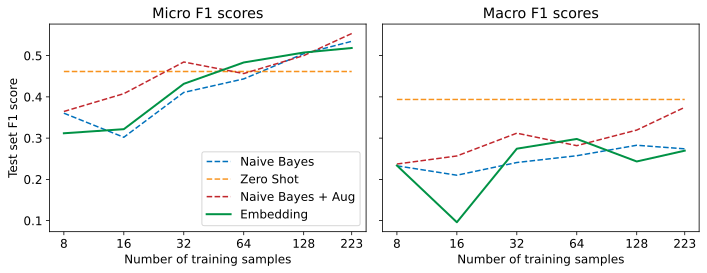

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

### 사이드바: FAISS를 사용한 효율적인 유사도 검색

<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_faiss-index.png?raw=1" id="faiss-index"/>

### 사이드바 끝

### 기본 트랜스포머 미세 튜닝하기

In [50]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)
                          
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [51]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [52]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0, 
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [53]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [54]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [55]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6715, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6364224553108215, 'eval_micro f1': 0.21786492374727667, 'eval_macro f1': 0.11133634201480808, 'eval_runtime': 0.6555, 'eval_samples_per_second': 161.718, 'eval_steps_per_second': 6.103, 'epoch': 1.0}
{'loss': 0.6171, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5777031779289246, 'eval_micro f1': 0.0837696335078534, 'eval_macro f1': 0.04535742035742036, 'eval_runtime': 0.6398, 'eval_samples_per_second': 165.674, 'eval_steps_per_second': 6.252, 'epoch': 2.0}
{'loss': 0.5612, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5435320734977722, 'eval_micro f1': 0.11458333333333331, 'eval_macro f1': 0.04589528118939883, 'eval_runtime': 0.6506, 'eval_samples_per_second': 162.931, 'eval_steps_per_second': 6.148, 'epoch': 3.0}
{'loss': 0.5047, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.5022798180580139, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6408, 'eval_samples_per_second': 165.

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6092, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5587261915206909, 'eval_micro f1': 0.05309734513274336, 'eval_macro f1': 0.011904761904761906, 'eval_runtime': 0.6487, 'eval_samples_per_second': 163.402, 'eval_steps_per_second': 6.166, 'epoch': 1.0}
{'loss': 0.5162, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4804303050041199, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6497, 'eval_samples_per_second': 163.141, 'eval_steps_per_second': 6.156, 'epoch': 2.0}
{'loss': 0.455, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4378034174442291, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6478, 'eval_samples_per_second': 163.634, 'eval_steps_per_second': 6.175, 'epoch': 3.0}
{'loss': 0.4109, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.41088274121284485, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6502, 'eval_samples_per_second': 163.036, 'eval_steps_per_second': 6.152, 'epoch': 4.0}
{'loss': 0.

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5812, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5000432133674622, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6583, 'eval_samples_per_second': 161.016, 'eval_steps_per_second': 6.076, 'epoch': 1.0}
{'loss': 0.4508, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.42097991704940796, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6626, 'eval_samples_per_second': 159.982, 'eval_steps_per_second': 6.037, 'epoch': 2.0}
{'loss': 0.392, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3854641914367676, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6685, 'eval_samples_per_second': 158.552, 'eval_steps_per_second': 5.983, 'epoch': 3.0}
{'loss': 0.3493, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3675495386123657, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6731, 'eval_samples_per_second': 157.482, 'eval_steps_per_second': 5.943, 'epoch': 4.0}
{'loss': 0.3239, 'learning_rate': 3e-05, 'ep

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5361, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4313732087612152, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.668, 'eval_samples_per_second': 158.685, 'eval_steps_per_second': 5.988, 'epoch': 1.0}
{'loss': 0.3959, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.37607693672180176, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6827, 'eval_samples_per_second': 155.262, 'eval_steps_per_second': 5.859, 'epoch': 2.0}
{'loss': 0.3551, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.35717666149139404, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6668, 'eval_samples_per_second': 158.962, 'eval_steps_per_second': 5.999, 'epoch': 3.0}
{'loss': 0.3369, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3451480269432068, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6924, 'eval_samples_per_second': 153.102, 'eval_steps_per_second': 5.777, 'epoch': 4.0}
{'loss': 0.3143, 'learning_rate': 3e-05, 'e

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4589, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.3725036382675171, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6756, 'eval_samples_per_second': 156.899, 'eval_steps_per_second': 5.921, 'epoch': 1.0}
{'loss': 0.3489, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3449938893318176, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6735, 'eval_samples_per_second': 157.394, 'eval_steps_per_second': 5.939, 'epoch': 2.0}
{'loss': 0.3156, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.33169594407081604, 'eval_micro f1': 0.23357664233576642, 'eval_macro f1': 0.08672086720867207, 'eval_runtime': 0.6719, 'eval_samples_per_second': 157.758, 'eval_steps_per_second': 5.953, 'epoch': 3.0}
{'loss': 0.2932, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.2953539192676544, 'eval_micro f1': 0.33103448275862074, 'eval_macro f1': 0.14074074074074072, 'eval_runtime': 0.6744, 'eval_samples_per_second': 157.175, 'eval_steps_per_second': 

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4265, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.35850396752357483, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6874, 'eval_samples_per_second': 154.2, 'eval_steps_per_second': 5.819, 'epoch': 1.0}
{'loss': 0.3312, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.32258322834968567, 'eval_micro f1': 0.15267175572519082, 'eval_macro f1': 0.0634920634920635, 'eval_runtime': 0.6813, 'eval_samples_per_second': 155.581, 'eval_steps_per_second': 5.871, 'epoch': 2.0}
{'loss': 0.2871, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.28632351756095886, 'eval_micro f1': 0.392156862745098, 'eval_macro f1': 0.15707070707070706, 'eval_runtime': 0.6997, 'eval_samples_per_second': 151.485, 'eval_steps_per_second': 5.716, 'epoch': 3.0}
{'loss': 0.2439, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.25138136744499207, 'eval_micro f1': 0.5029940119760479, 'eval_macro f1': 0.24774757026530075, 'eval_runtime': 0.7049, 'eval_samples_per_second': 150.3

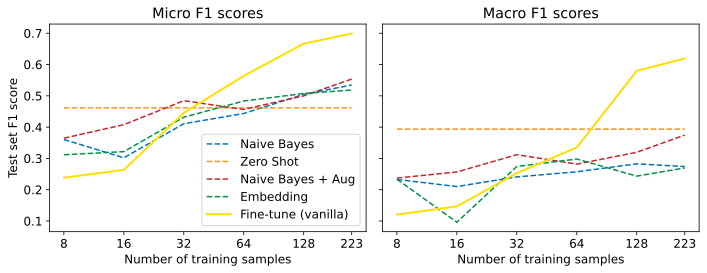

In [56]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### 프롬프트를 사용한 인-컨텍스트 학습과 퓨-샷 학습

In [57]:
prompt = """\
Translate English to French:
thanks =>
"""

## 레이블링되지 않은 데이터 활용하기

### 언어 모델 미세 튜닝하기

In [58]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [59]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [60]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
original_input_ids = inputs["input_ids"][0]
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [61]:
data_collator.return_tensors = "pt"

In [1]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [62]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

Cloning https://huggingface.co/haesun/bert-base-uncased-issues-128 into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/418M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Clean file training_args.bin:  30%|###       | 1.00k/3.30k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/418M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 2.0986, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6929024457931519, 'eval_runtime': 1.9399, 'eval_samples_per_second': 114.954, 'eval_steps_per_second': 14.434, 'epoch': 1.0}
{'loss': 1.6401, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.4303563833236694, 'eval_runtime': 1.9454, 'eval_samples_per_second': 114.632, 'eval_steps_per_second': 14.393, 'epoch': 2.0}
{'loss': 1.4881, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.391607642173767, 'eval_runtime': 1.9392, 'eval_samples_per_second': 114.997, 'eval_steps_per_second': 14.439, 'epoch': 3.0}
{'loss': 1.4, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.379551887512207, 'eval_runtime': 1.9449, 'eval_samples_per_second': 114.659, 'eval_steps_per_second': 14.397, 'epoch': 4.0}
{'loss': 1.3416, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.2011953592300415, 'eval_runtime': 1.9373, 'eval_samples_per_second': 115.107, 'eval_steps_per_second':

TrainOutput(global_step=4656, training_loss=1.2819018413111107, metrics={'train_runtime': 3724.7767, 'train_samples_per_second': 39.962, 'train_steps_per_second': 1.25, 'train_loss': 1.2819018413111107, 'epoch': 16.0})

In [63]:
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/bert-base-uncased-issues-128
   dcea9b4..f1ac742  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/bert-base-uncased-issues-128
   dcea9b4..f1ac742  main -> main

To https://huggingface.co/haesun/bert-base-uncased-issues-128
   f1ac742..4d7bdc9  main -> main

   f1ac742..4d7bdc9  main -> main



'https://huggingface.co/haesun/bert-base-uncased-issues-128/commit/f1ac74251dbec43d8741b17569c57d7eb2f08dd0'

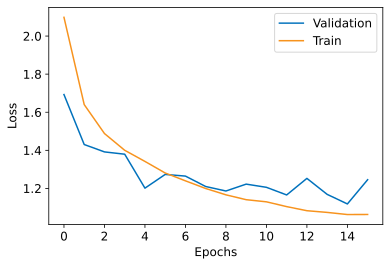

In [64]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### 분류기 미세 튜닝하기

In [65]:
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA는 도메인 적응을 의미합니다
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.638, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5546548962593079, 'eval_micro f1': 0.016260162601626015, 'eval_macro f1': 0.013071895424836602, 'eval_runtime': 0.6716, 'eval_samples_per_second': 157.844, 'eval_steps_per_second': 5.956, 'epoch': 1.0}
{'loss': 0.5082, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4763641059398651, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6831, 'eval_samples_per_second': 155.168, 'eval_steps_per_second': 5.855, 'epoch': 2.0}
{'loss': 0.4256, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4306841194629669, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6736, 'eval_samples_per_second': 157.355, 'eval_steps_per_second': 5.938, 'epoch': 3.0}
{'loss': 0.3883, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4021003544330597, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.683, 'eval_samples_per_second': 155.192, 'eval_steps_per_second': 5.856, 'epoch': 4.0}
{'loss': 0.3

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6145, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5137366652488708, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6998, 'eval_samples_per_second': 151.481, 'eval_steps_per_second': 5.716, 'epoch': 1.0}
{'loss': 0.4536, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4247235059738159, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6984, 'eval_samples_per_second': 151.786, 'eval_steps_per_second': 5.728, 'epoch': 2.0}
{'loss': 0.3775, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.38813337683677673, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7042, 'eval_samples_per_second': 150.532, 'eval_steps_per_second': 5.68, 'epoch': 3.0}
{'loss': 0.3369, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3713938593864441, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6985, 'eval_samples_per_second': 151.763, 'eval_steps_per_second': 5.727, 'epoch': 4.0}
{'loss': 0.3166, 'learning_rate': 3e-05, 'ep

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.555, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4370964467525482, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7028, 'eval_samples_per_second': 150.831, 'eval_steps_per_second': 5.692, 'epoch': 1.0}
{'loss': 0.3834, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3760508894920349, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7036, 'eval_samples_per_second': 150.652, 'eval_steps_per_second': 5.685, 'epoch': 2.0}
{'loss': 0.335, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3590487837791443, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7015, 'eval_samples_per_second': 151.109, 'eval_steps_per_second': 5.702, 'epoch': 3.0}
{'loss': 0.303, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3477003276348114, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7107, 'eval_samples_per_second': 149.139, 'eval_steps_per_second': 5.628, 'epoch': 4.0}
{'loss': 0.2774, 'learning_rate': 3e-05, 'epoch

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4916, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.37976905703544617, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.695, 'eval_samples_per_second': 152.525, 'eval_steps_per_second': 5.756, 'epoch': 1.0}
{'loss': 0.3556, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.35115426778793335, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.702, 'eval_samples_per_second': 150.991, 'eval_steps_per_second': 5.698, 'epoch': 2.0}
{'loss': 0.3197, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.32826006412506104, 'eval_micro f1': 0.07999999999999999, 'eval_macro f1': 0.03831417624521073, 'eval_runtime': 0.6907, 'eval_samples_per_second': 153.463, 'eval_steps_per_second': 5.791, 'epoch': 3.0}
{'loss': 0.2845, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.31151413917541504, 'eval_micro f1': 0.27142857142857135, 'eval_macro f1': 0.1089430894308943, 'eval_runtime': 0.7021, 'eval_samples_per_second': 150.968, 'eval_steps_per_second': 

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4251, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.35266098380088806, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6901, 'eval_samples_per_second': 153.605, 'eval_steps_per_second': 5.796, 'epoch': 1.0}
{'loss': 0.3278, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3160582482814789, 'eval_micro f1': 0.22058823529411764, 'eval_macro f1': 0.08333333333333333, 'eval_runtime': 0.6916, 'eval_samples_per_second': 153.26, 'eval_steps_per_second': 5.783, 'epoch': 2.0}
{'loss': 0.2798, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.29334360361099243, 'eval_micro f1': 0.35064935064935066, 'eval_macro f1': 0.12332404088676491, 'eval_runtime': 0.6869, 'eval_samples_per_second': 154.322, 'eval_steps_per_second': 5.823, 'epoch': 3.0}
{'loss': 0.2345, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.24705927073955536, 'eval_micro f1': 0.5030674846625767, 'eval_macro f1': 0.2585048722827653, 'eval_runtime': 0.6885, 'eval_samples_per_second': 153

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.3977, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.33050593733787537, 'eval_micro f1': 0.2222222222222222, 'eval_macro f1': 0.08547008547008547, 'eval_runtime': 0.7056, 'eval_samples_per_second': 150.222, 'eval_steps_per_second': 5.669, 'epoch': 1.0}
{'loss': 0.3015, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.29277554154396057, 'eval_micro f1': 0.29577464788732394, 'eval_macro f1': 0.10144927536231883, 'eval_runtime': 0.7092, 'eval_samples_per_second': 149.459, 'eval_steps_per_second': 5.64, 'epoch': 2.0}
{'loss': 0.2475, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.22906634211540222, 'eval_micro f1': 0.5647058823529413, 'eval_macro f1': 0.30859958727673803, 'eval_runtime': 0.7047, 'eval_samples_per_second': 150.428, 'eval_steps_per_second': 5.677, 'epoch': 3.0}
{'loss': 0.1781, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.198102205991745, 'eval_micro f1': 0.6559139784946235, 'eval_macro f1': 0.5014512739690046, 'eval_runtime': 0.6982, '

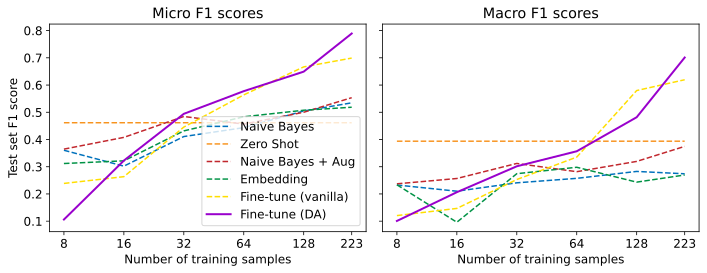

In [66]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

### 고급 방법

#### 비지도 데이터 증식

<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_uda.png?raw=1" id="uda"/>    

#### 불확실성 인지 자기 훈련

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_ust.png?raw=1" id="ust"/>

## 결론